# Model Comparator

In this notebook, I will code some interesting functions to compare all models made to predict the KS system.

In [1]:
import numpy as np
import torch as th
import time
from scipy import stats
#from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
#Set a javascript interval to click on the connect button every 60 seconds. 
#Open developer-settings (in your web-browser) with Ctrl+Shift+i then click 
#on console tab and type this on the console prompt.
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

In [2]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [3]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [4]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [5]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [6]:
def prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+(N_step_simu*steps_to_predict),:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_simu, steps_to_predict,sample_points))

    for i in range(N_step_simu):
        y=model(current_state)
        yy=y[0].reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[i,:,:]=yy
        y=y.reshape(1,sample_points,steps_to_predict)
        past=current_state[:,:,steps_to_predict:size_conv_time]
        current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
        current_state[:,:,0:(size_conv_time-steps_to_predict)]=past
        current_state[:,:,(size_conv_time-steps_to_predict):]=y


    prediction_model_np = prediction_model.detach().numpy()
    prediction_model_np= prediction_model_np.reshape(N_step_simu*steps_to_predict,sample_points)
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    #print('The true solution:')
    #drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4) 
    #print('The model solution:')
    #drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)

    #plt.plot(np.absolute(dif))
    #plt.title('Difference between prediction and true value')
    #plt.ylabel('Delta')
    #plt.xlabel('Time step')
    
    return prediction_model_np,y_true_np, np.absolute(dif)

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [7]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u1.dat') #the observed initial state of the system

In [8]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators


In [9]:
cd ../Simulators/ks-simulator/dataset1_u3/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset1_u3


In [10]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

Mean: 0.0037720958739586776
Median: 0.02334210639889245
Max: 0.4565350850600155
Min: -0.4433889069435318
Mode: ModeResult(mode=array([-0.44338891]), count=array([1]))
Variance: 0.05437736519905126


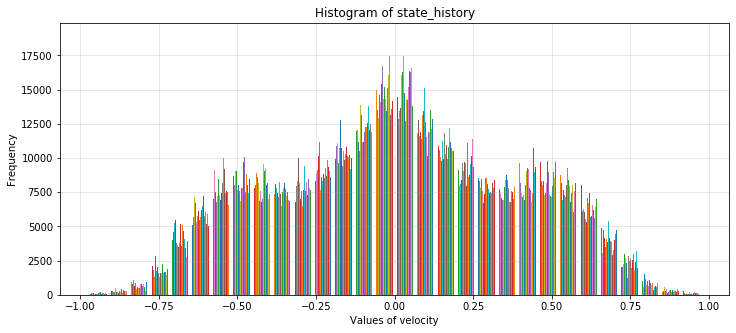

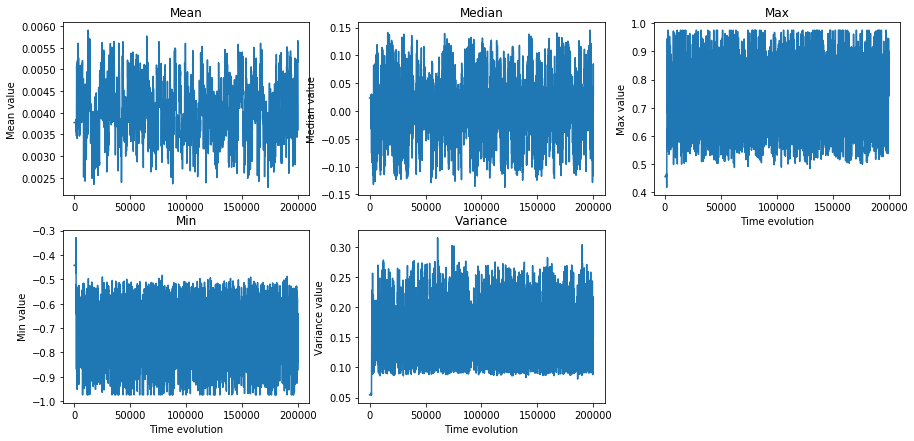

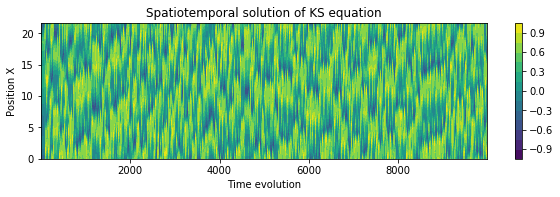

In [11]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

#KSflow
drawKS(state_history_norm, position_x, time_counter ,startT=1,endT=200000, width = 10, divwidth = 4)

In [12]:
state_history_norm=state_history_norm[:50000,:]
#até 100.000 vai, com 200.000 o colabs nao aguenta
state_history_norm.shape

(50000, 64)

In [14]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [17]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


## Loading the models that we wanna compare

In [54]:
Number_of_Models = 2

total_prediction = 1000

positions = [200,3000,150000]

delta_all_model_sp200 = np.zeros((Number_of_Models, total_prediction))
delta_all_model_sp3000 = np.zeros((Number_of_Models, total_prediction))
delta_all_model_sp150000 = np.zeros((Number_of_Models, total_prediction))

Sequential(
  (0): Conv1d(64, 128, kernel_size=(10,), stride=(2,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(128, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool1d(kernel_size=12, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=64, out_features=320, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=320, out_features=640, bias=True)
  (10): Tanh()
)
Model's state_dict:
0.weight 	 torch.Size([128, 64, 10])
0.bias 	 torch.Size([128])
3.weight 	 torch.Size([64, 128, 5])
3.bias 	 torch.Size([64])
7.weight 	 torch.Size([320, 64])
7.bias 	 torch.Size([320])
9.weight 	 torch.Size([640, 320])
9.bias 	 torch.Size([640])
epoch: 500
batch_size: 64
loss: MSELoss()


(0, 3.9661563994588044e-05)

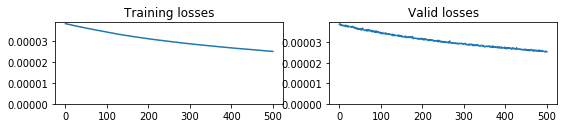

In [26]:
#TO LOAD THE MODEL. 

# Load the pickle file to read the dictionnary from the file
checkpoint = th.load("")

# restore the model and optimizer states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']


# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("epoch:", epoch)
print("batch_size:", batch_size)
print("loss:", loss_fn)
    
# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

#plot some graphs
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 2, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)

Start_position= 200
The true solution:


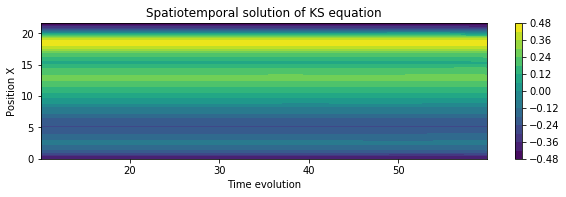

The model solution:


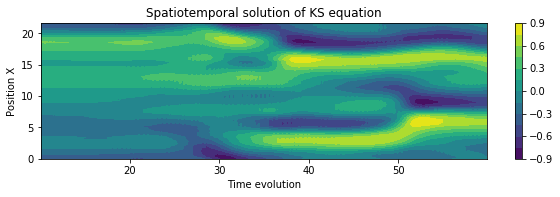

Start_position= 3000
The true solution:


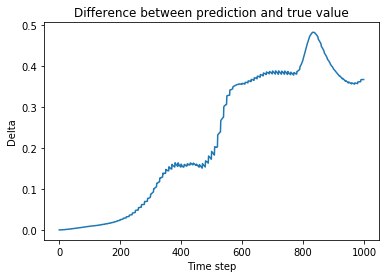

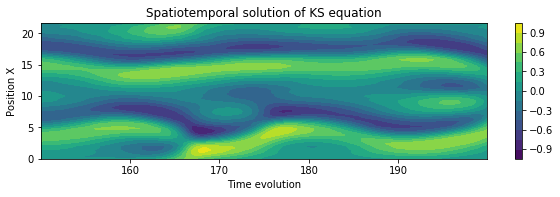

The model solution:


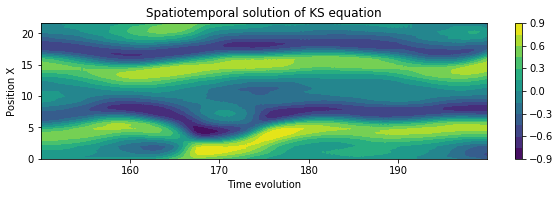

Start_position= 150000
The true solution:


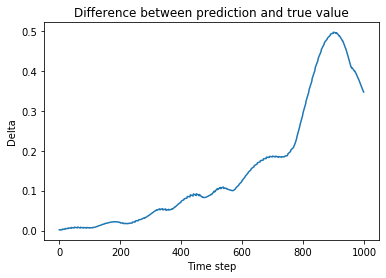

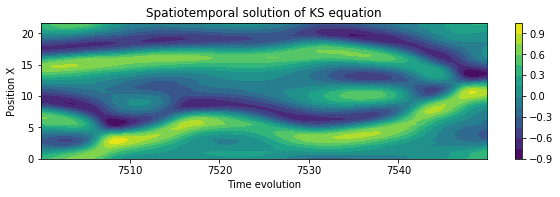

The model solution:


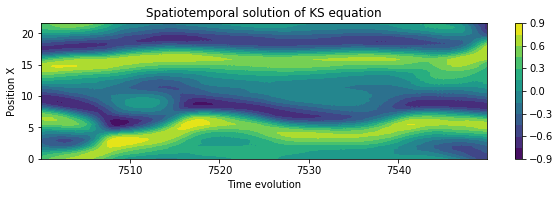

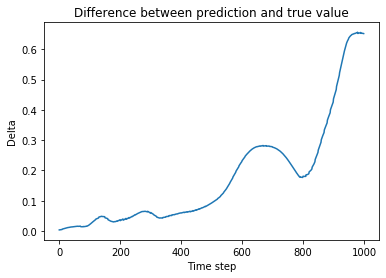

In [57]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_simu=100
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp200[0,:] = dif

start_position=3000
N_step_simu=100
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp3000[0,:] = dif

start_position=150000
N_step_simu=100
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp150000[0,:] = dif

## Comparing the models for different start_position

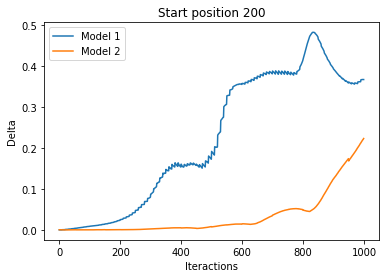

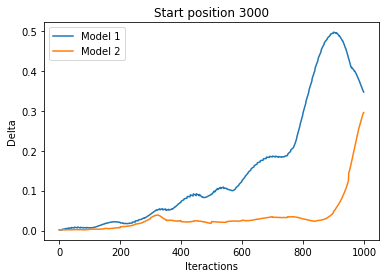

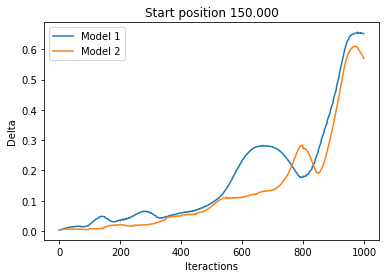

In [98]:
plt.plot(delta_all_model_sp200[0,:])
plt.plot(delta_all_model_sp200[1,:])
plt.legend(['Model 1','Model 2'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 200')
plt.show()

plt.plot(delta_all_model_sp3000[0,:])
plt.plot(delta_all_model_sp3000[1,:])
plt.legend(['Model 1','Model 2'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 3000')
plt.show()

plt.plot(delta_all_model_sp150000[0,:])
plt.plot(delta_all_model_sp150000[1,:])
plt.legend(['Model 1','Model 2'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 150.000')
plt.show()

## Comparing the model with different training epochs

In [14]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [15]:
cd ../ks-simulator/differents_epochs/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\differents_epochs


In [18]:
size_conv_time=150
steps_to_predict=50

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 4
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 5
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = int(sample_points*L_5)
hidden_1 = sample_points*25
out_lin = sample_points*steps_to_predict

model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [19]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [39]:
start_position=40000
N_step_simu=20

Iteractions_Epochs = 34

comparator = np.zeros((Iteractions_Epochs,1))

for i in range(Iteractions_Epochs):
    # Load the pickle file to read the dictionnary from the file
    checkpoint = th.load(str(i))
    # restore the model and optimizer states: 
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #making the prediction
    pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
    comparator[i] = np.mean(dif)


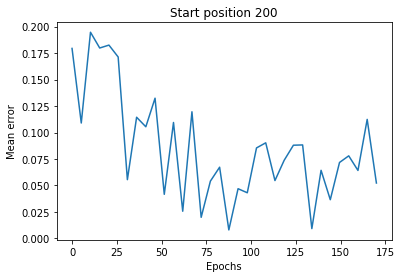

In [38]:
plt.plot(np.linspace(0,170,34),comparator)
plt.ylabel('Mean error')
plt.xlabel('Epochs')
plt.title('Start position 200')
plt.show()

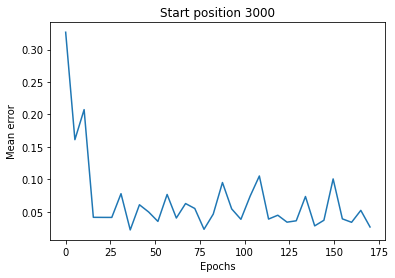

In [36]:
plt.plot(np.linspace(0,170,34),comparator)
plt.ylabel('Mean error')
plt.xlabel('Epochs')
plt.title('Start position 3000')
plt.show()

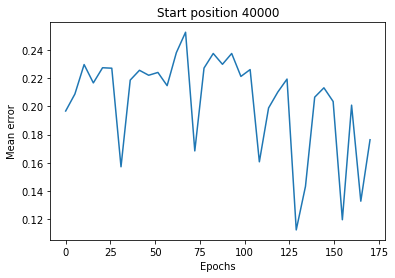

In [40]:
plt.plot(np.linspace(0,170,34),comparator)
plt.ylabel('Mean error')
plt.xlabel('Epochs')
plt.title('Start position 40000')
plt.show()

## Comparing the model with different history size

In [ ]:
#start_position=200

start_position=200
N_step_simu=100

Number_of_models = 10

comparator = np.zeros(Number_of_models,1)

for i in range(Number_of_models):
    size_conv_time=10*i
    steps_to_predict=50
    Lin = size_conv_time
    in_ch_conv_1 = 64
    out_ch_conv_1 = 128
    k_conv_1 = 4
    st_conv_1 = 2
    pad_conv_1 = 4
    L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1
    k_pool_1= 2
    st_pool_1= 2
    L_3 = (L_2 - k_pool_1)/st_pool_1 + 1
    in_ch_conv_2 = 128
    out_ch_conv_2 = 64
    k_conv_2 = 5
    st_conv_2 = 2
    pad_conv_2 = 1
    L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1
    k_pool_2= 5
    st_pool_2= 2
    L_5 = (L_4 - k_pool_2)/st_pool_2 + 1
    in_lin = int(sample_points*L_5)
    hidden_1 = sample_points*25
    out_lin = sample_points*steps_to_predict
    model = th.nn.Sequential(
        th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_1,st_pool_1),
        th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_2,st_pool_2),
        th.nn.Flatten(),
        th.nn.Linear(in_lin,hidden_1),
        th.nn.LeakyReLU(),
        th.nn.Linear(hidden_1,out_lin),
        th.nn.Tanh(),
    )
    model.double()
    model.cuda()
    optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
    loss_fn=th.nn.MSELoss()
    
    # Load the pickle file to read the dictionnary from the file
    checkpoint = th.load(str(i))
    # restore the model and optimizer states: 
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #making the prediction
    pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
    comparator[i] = np.mean(dif)



In [ ]:
plt.plot(np.linspace(0,250,5),comparator)
plt.ylabel('Mean error')
plt.xlabel('Epochs')
plt.title('Start position 200')
plt.show()

## Comparing the model with different steps_to_predict

In [17]:
cd ../ks-simulator/different_steps_to_predict/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\different_steps_to_predict


In [19]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [49]:
start_position=40000

N_step_simu=20


Number_of_models = 10

comparator = np.zeros((Number_of_models,1))

for i in range(Number_of_models):
    size_conv_time=150
    steps_to_predict=5*(i+1)
    #N_step_simu=int(1000/steps_to_predict)
    Lin = size_conv_time
    in_ch_conv_1 = 64
    out_ch_conv_1 = 128
    k_conv_1 = 4
    st_conv_1 = 2
    pad_conv_1 = 4
    L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1
    k_pool_1= 2
    st_pool_1= 2
    L_3 = (L_2 - k_pool_1)/st_pool_1 + 1
    in_ch_conv_2 = 128
    out_ch_conv_2 = 64
    k_conv_2 = 5
    st_conv_2 = 2
    pad_conv_2 = 1
    L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1
    k_pool_2= 5
    st_pool_2= 2
    L_5 = (L_4 - k_pool_2)/st_pool_2 + 1
    in_lin = int(sample_points*L_5)
    hidden_1 = sample_points*25
    out_lin = sample_points*steps_to_predict
    model = th.nn.Sequential(
        th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_1,st_pool_1),
        th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_2,st_pool_2),
        th.nn.Flatten(),
        th.nn.Linear(in_lin,hidden_1),
        th.nn.LeakyReLU(),
        th.nn.Linear(hidden_1,out_lin),
        th.nn.Tanh(),
    )
    model.double()
    model.cuda()
    optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
    loss_fn=th.nn.MSELoss()
    
    # Load the pickle file to read the dictionnary from the file
    checkpoint = th.load(str(i))
    # restore the model and optimizer states: 
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #making the prediction
    pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
    comparator[i] = np.mean(dif)

In [27]:
dif.shape

(1000,)

In [22]:
comparator.shape

(10, 1)

In [37]:
np.linspace(5,50,10)

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

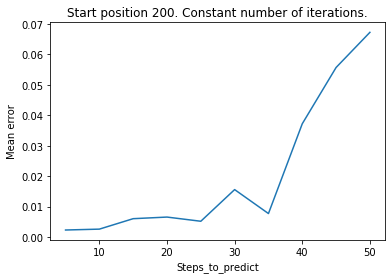

In [46]:
plt.plot(np.linspace(5,50,10),comparator)
plt.ylabel('Mean error')
plt.xlabel('Steps_to_predict')
plt.title('Start position 200. Constant number of iterations.')
plt.show()

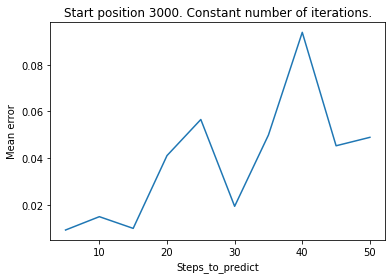

In [48]:
plt.plot(np.linspace(5,50,10),comparator)
plt.ylabel('Mean error')
plt.xlabel('Steps_to_predict')
plt.title('Start position 3000. Constant number of iterations.')
plt.show()

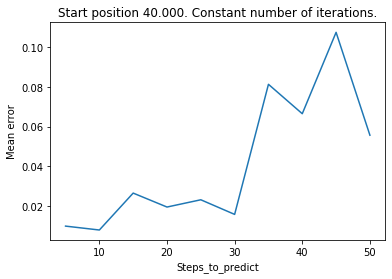

In [50]:
plt.plot(np.linspace(5,50,10),comparator)
plt.ylabel('Mean error')
plt.xlabel('Steps_to_predict')
plt.title('Start position 40.000. Constant number of iterations.')
plt.show()

## Testing if the model can predict different datasets

In [44]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [45]:
size_conv_time=150
steps_to_predict=50

Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 4
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 5
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = int(sample_points*L_5)
hidden_1 = sample_points*25
out_lin = sample_points*steps_to_predict

model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

# Load the pickle file to read the dictionnary from the file
checkpoint = th.load("modelcv3_model2_u3")

# restore the model and optimizer states: 
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.MSELoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [46]:
Number_of_Models = 4

N_step_simu=100

total_prediction = 100*steps_to_predict

positions = [200,3000,40000]

delta_all_model_sp200 = np.zeros((Number_of_Models, total_prediction))
delta_all_model_sp3000 = np.zeros((Number_of_Models, total_prediction))
delta_all_model_sp40000 = np.zeros((Number_of_Models, total_prediction))

In [59]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [60]:
cd ../ks-simulator/dataset1_u4/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset1_u4


In [61]:
#load dataset

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u4.dat')
time_counter = np.loadtxt('time_counter_u4.dat')
position_x = np.loadtxt('position_u4.dat')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)
state_history_norm = state_history_norm[:50000,:]
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


In [62]:
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp200[3,:] = dif

start_position=3000
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp3000[3,:] = dif

start_position=40000
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp40000[3,:] = dif

Start_position= 200
Start_position= 3000


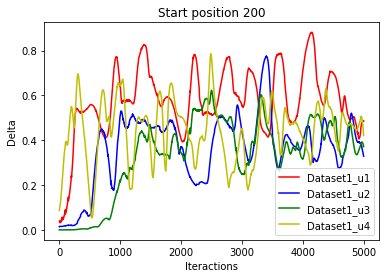

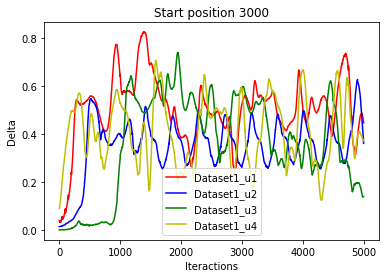

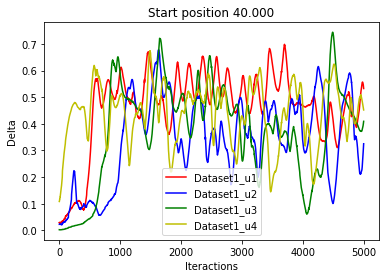

In [69]:
plt.plot(delta_all_model_sp200[0,:],'r')
plt.plot(delta_all_model_sp200[1,:],'b')
plt.plot(delta_all_model_sp200[2,:],'g')
plt.plot(delta_all_model_sp200[3,:],'y')
plt.legend(['Dataset1_u1','Dataset1_u2','Dataset1_u3','Dataset1_u4'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 200')
plt.show()

plt.plot(delta_all_model_sp3000[0,:],'r')
plt.plot(delta_all_model_sp3000[1,:],'b')
plt.plot(delta_all_model_sp3000[2,:],'g')
plt.plot(delta_all_model_sp3000[3,:],'y')
plt.legend(['Dataset1_u1','Dataset1_u2','Dataset1_u3','Dataset1_u4'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 3000')
plt.show()

plt.plot(delta_all_model_sp40000[0,:],'r')
plt.plot(delta_all_model_sp40000[1,:],'b')
plt.plot(delta_all_model_sp40000[2,:],'g')
plt.plot(delta_all_model_sp40000[3,:],'y')
plt.legend(['Dataset1_u1','Dataset1_u2','Dataset1_u3','Dataset1_u4'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 40.000')
plt.show()